## Imports and Settings

In [ ]:
import json
from datetime import datetime, time, timedelta
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import math
from typing import *
import statistics
import matplotlib.cm as cm
import seaborn as sns
# from geojson_creator import GeoJSONCreator, VehicleGeoJSONCreator
from typing import Dict
import ast
import requests
from pymongo import MongoClient, errors
from bson.json_util import dumps
from scipy.spatial import ConvexHull
from geopy.distance import geodesic
from shapely.geometry import Point


### Flags & Settings

#### Enable plot UI backend

In [ ]:
# %matplotlib tk

In [ ]:
PLOT_FOLDER_PATH = "./Plots/"

## **Skip** API calls (**fetch from DB**)

In [ ]:
# Flags
SKIP_API_CALLS = True

## Fetch from DB

In [ ]:
if not SKIP_API_CALLS:  # *Fetch from DB
    try:
        # Connect to MongoDB
        client = MongoClient("mongodb://localhost:27017/", serverSelectionTimeoutMS=5000)  # 5s timeout
        db = client["Ptyxiaki"]
        collection = db["Powerfleet GPS"]

        # Test connection
        client.server_info()  # *Raises an error if connection fails

        # Fetch all documents from the collection
        cursor = collection.find()

        # Convert to a DataFrame
        merged_dfs = pd.DataFrame(list(cursor))

        # *Drop MongoDB's default '_id' column 
        if "_id" in merged_dfs.columns:
            merged_dfs.drop(columns=["_id"], inplace=True)
        
        # Display the DataFrame
        print(Fore.GREEN + "Data Fetched Successfully" + Style.RESET_ALL)
        print(merged_dfs.head())

    except errors.ServerSelectionTimeoutError:
        print("Error: Unable to connect to MongoDB. Check if the server is running.", file=sys.stderr)
        merged_dfs = None
    except errors.ConnectionFailure:
        print("Error: Connection to MongoDB failed.", file=sys.stderr)
        merged_dfs = None
    except Exception as e:
        print(f"Unexpected Error: {e}", file=sys.stderr)
        merged_dfs = None
else:
    print(Fore.YELLOW + "Cell Skipped" + Style.RESET_ALL)


## Update <u>PARAMETERS.json</u> with **current** date and time

In [ ]:
if not SKIP_API_CALLS:
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    file_path = "PARAMETERS.json" 

    # Get the current date and time
    current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
    current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

    # Check if the file exists and is not empty
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
        exit()

    # Check if the file is empty
    if os.path.getsize(file_path) == 0:
        print(f"Error: The file '{file_path}' is empty.")
        exit()

    # Load the current JSON data
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON. Details: {e}")
        exit()

    # Combine the date and time
    combined_datetime = current_datetime + " " + current_time

    # Update the 'endDate' field in the 'snapshot_api' section
    data["snapshot_api"]["endDate"] = combined_datetime

    # Save the updated JSON data back to the file
    try:
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
        print(f"Updated PARAMETERS.json with: {combined_datetime}.")
    except Exception as e:
        print(f"Error: Failed to save the updated file. Details: {e}")


## Ready variables for APIs usage

In [ ]:
if not SKIP_API_CALLS:
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
    print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

    # Define the ApiParameterExtractor class
    class ApiParameterExtractor:
        def __init__(self, json_file):
            with open(json_file, 'r') as file:
                self.parameters = json.load(file)

        def extract_parameters(self, api_type):
            # Normalize API type to lowercase
            api_type = api_type.lower()
            
            # Validate API type
            if api_type not in self.parameters:
                raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
            
            # Return the corresponding dictionary for the given API type
            return self.parameters[api_type]

    extractor = ApiParameterExtractor("PARAMETERS.json")

    # Extract parameters for live_api and snapshot_api
    live_api_params         = extractor.extract_parameters("live_api")
    snapshot_api_params     = extractor.extract_parameters("snapshot_api")

    # Pass the extracted parameters to PowerFleetAPIsManager
    live_api_manager        = ApiManager(live_api_params)
    snapshot_api_manager    = ApiManager(snapshot_api_params)




## Fetch Live & Snapshot APIs

In [ ]:
if not SKIP_API_CALLS:
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    # === Function to Save DataFrame to CSV ===
    def save_to_csv(dataframe, output_dir, file_name):
        """
        Save a DataFrame to a specified CSV file in the given directory.
        
        :param dataframe: The DataFrame to save.
        :param output_dir: The directory where the CSV file will be saved.
        :param file_name: The name of the CSV file (e.g., "file_name.csv").
        """
        if not dataframe.empty:  # Only save if the DataFrame is not empty
            os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
            file_path = Path(output_dir) / file_name  # Construct the full file path
            dataframe.to_csv(file_path, index=False)  # Overwrite the CSV file by default
            print(f"Data saved to {file_path}")
        else:
            print(f"No data to save for {file_name}. Skipping...")

    # === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
    def unix_to_datetime_pandas(dataframe, column_name):
        """
        Convert a UNIX timestamp column to human-readable datetime format.
        
        :param dataframe: The DataFrame containing the column.
        :param column_name: The column name containing UNIX timestamps.
        """
        if column_name in dataframe.columns:
            try:
                dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
                print(f"Converted '{column_name}' to human-readable datetime.")
            except Exception as e:
                print(f"Error converting column '{column_name}': {e}")
        else:
            print(f"Column '{column_name}' not found in DataFrame.")


    def merge_merged_dfs(ALL_merged_dfsS):
        result = pd.concat(ALL_merged_dfsS, ignore_index=True)
        print(type(result))
        return result
        
        
    # === Constants ===
    target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"

    # === Step 3: Load Parameters from JSON File ===
    with open("PARAMETERS.json", "r") as file:
        PARAMETERS = json.load(file)  # Load API parameters from the JSON file

    # === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
    _cnt = 1  # Counter for vehicle IDs
    snapshot_data = None  # Initialize snapshot_data to enter the loop


    ALL_merged_dfsS = []

    while _cnt <= 20:  # Run for up to 100 times
        # Update the vehicleId in PARAMETERS
        PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
        
        # Extract updated vehicleId and fetch snapshot data
        vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
        startDate = PARAMETERS["snapshot_api"]["startDate"]
        endDate = PARAMETERS["snapshot_api"]["endDate"]
        
        # Fetch snapshot data (Returns JSON)
        snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
        
        # Skip if no data is found (None or empty data)
        if not snapshot_data:
            print(f"No data found for vehicleId {vehicleId}. Skipping...")
            _cnt += 1
            continue
        
        # Parse the JSON snapshot data into a DataFrame
        try:
            # If the snapshot data is a valid JSON string, parse it
            snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
            
            # Handle JSON structure (either dict or list)
            if isinstance(snapshot_data_dict, dict):
                snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
            elif isinstance(snapshot_data_dict, list):
                snapshot_data_list = snapshot_data_dict  # Already a list of dicts
            else:
                snapshot_data_list = []
            
            # Create a DataFrame from the list of dictionaries
            snapshot_merged_dfs = pd.DataFrame(snapshot_data_list)
                
            ALL_merged_dfsS.append(snapshot_merged_dfs)
            #save_to_csv(snapshot_merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")

            
            
        
        except json.JSONDecodeError as e:
            print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

        # Increment the vehicleId counter
        _cnt += 1
        

    merged_dfs = merge_merged_dfs(ALL_merged_dfsS)
    print(type(merged_dfs))
        
    # Save the DataFrame to CSV only if it's not empty
    save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")


    print("Process complete!")



# **Filter only Tripoli's BBOX**


In [ ]:
print(Fore.GREEN + f"Before filtering: {len(merged_dfs)} total rows")

#Define bounding box coordinates
tripoli_bbox = {
    'latMin': 37.49764419371479,
    'latMax': 37.56244081620044,
    'lngMin': 22.344992459074458,
    'lngMax': 22.521463853839485
}


# Filter the rows that are within the bounding box
merged_dfs = merged_dfs[(merged_dfs['lat'] >= tripoli_bbox['latMin']) & 
                        (merged_dfs['lat'] <= tripoli_bbox['latMax']) &
                        (merged_dfs['lng'] >= tripoli_bbox['lngMin']) & 
                        (merged_dfs['lng'] <= tripoli_bbox['lngMax'])]

print(f"After filtering: {len(merged_dfs)} total rows" + Style.RESET_ALL)

In [ ]:
merged_dfs = merge_merged_dfs(ALL_merged_dfsS)

# Print all unique vehicleId values from the merged DataFrame
unique_vehicle_ids = merged_dfs['vehicleId'].unique()
print(f"Unique vehicleIds in the merged DataFrame: {unique_vehicle_ids}")



## Visualize data **dispersion**

### Plot number of data lines of each vehicle

In [ ]:
# Check if API calls are skipped
if SKIP_API_CALLS:
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    # === Function to Save DataFrame to CSV ===
    def save_to_csv(dataframe, output_dir, file_name):
        """
        Save a DataFrame to a specified CSV file in the given directory.
        
        :param dataframe: The DataFrame to save.
        :param output_dir: The directory where the CSV file will be saved.
        :param file_name: The name of the CSV file (e.g., "file_name.csv").
        """
        if not dataframe.empty:  # Only save if the DataFrame is not empty
            os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
            file_path = Path(output_dir) / file_name  # Construct the full file path
            dataframe.to_csv(file_path, index=False)  # Overwrite the CSV file by default
            print(f"Data saved to {file_path}")
        else:
            print(f"No data to save for {file_name}. Skipping...")

    # === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
    def unix_to_datetime_pandas(dataframe, column_name):
        """
        Convert a UNIX timestamp column to human-readable datetime format.
        
        :param dataframe: The DataFrame containing the column.
        :param column_name: The column name containing UNIX timestamps.
        """
        if column_name in dataframe.columns:
            try:
                dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
                print(f"Converted '{column_name}' to human-readable datetime.")
            except Exception as e:
                print(f"Error converting column '{column_name}': {e}")
        else:
            print(f"Column '{column_name}' not found in DataFrame.")


    def merge_merged_dfs(ALL_merged_dfsS):
        result = pd.concat(ALL_merged_dfsS, ignore_index=True)
        print(type(result))
        return result
        
        
    # === Constants ===
    target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
    # snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

    # === Step 1: Load Parameters from JSON File ===
    with open("PARAMETERS.json", "r") as file:
        PARAMETERS = json.load(file)  # Load API parameters from the JSON file

    # === Step 2: Loop to Fetch and Append Data for Each Vehicle ===
    _cnt = 1  # Counter for vehicle IDs
    snapshot_data = None  # Initialize snapshot_data to enter the loop

    ALL_merged_dfsS = []

    while _cnt <= 20:  # Run for up to 100 times
        # Update the vehicleId in PARAMETERS
        PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
        
        # Fetch snapshot data (Returns JSON)
        snapshot_data = snapshot_api_manager.get_snapshot_data(str(_cnt), PARAMETERS["snapshot_api"]["startDate"], PARAMETERS["snapshot_api"]["endDate"])
        
        # Skip if no data is found (None or empty data)
        if not snapshot_data:
            print(f"No data found for vehicleId {str(_cnt)}. Skipping...")
            _cnt += 1
            continue
        
        # Parse the JSON snapshot data into a DataFrame
        try:
            snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
            
            if isinstance(snapshot_data_dict, dict):
                snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
            elif isinstance(snapshot_data_dict, list):
                snapshot_data_list = snapshot_data_dict  # Already a list of dicts
            else:
                snapshot_data_list = []
            
            snapshot_merged_dfs = pd.DataFrame(snapshot_data_list)
            ALL_merged_dfsS.append(snapshot_merged_dfs)
            
        except json.JSONDecodeError as e:
            print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

        # Increment the vehicleId counter
        _cnt += 1
        

    # Merge all DataFrames
    merged_dfs = merge_merged_dfs(ALL_merged_dfsS)
    print(type(merged_dfs))
        
    # Save the DataFrame to CSV only if it's not empty
    save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")
    
    # === Step 3: Filtering Data within Bounding Box for Tripoli ===
    print(Fore.GREEN + f"Before filtering: {len(merged_dfs)} total rows")

    # Define bounding box coordinates for Tripoli
    tripoli_bbox = {
        'latMin': 37.49764419371479,
        'latMax': 37.56244081620044,
        'lngMin': 22.344992459074458,
        'lngMax': 22.521463853839485
    }

    # Filter the rows that are within the bounding box
    merged_dfs = merged_dfs[(merged_dfs['lat'] >= tripoli_bbox['latMin']) & 
                            (merged_dfs['lat'] <= tripoli_bbox['latMax']) &
                            (merged_dfs['lng'] >= tripoli_bbox['lngMin']) & 
                            (merged_dfs['lng'] <= tripoli_bbox['lngMax'])]

    print(f"After filtering: {len(merged_dfs)} total rows" + Style.RESET_ALL)
    
    # === Step 4: Collect Unique Vehicle IDs and Rows Count ===
    unique_veh_ids = []
    vehicle_rows = []

    # Ensure there is data to process
    if not ALL_merged_dfsS:
        print("No data found to process!")
    else:
        # Iterate over the list of all merged DataFrames
        for individual_df in ALL_merged_dfsS:
            if not individual_df.empty and 'vehicleId' in individual_df.columns:
                unique_veh_ids.append(individual_df['vehicleId'].values[0])  # Extract the vehicle ID
                vehicle_rows.append(len(individual_df))  # Count the number of rows in the DataFrame
            else:
                print(f"Warning: DataFrame is empty or 'vehicleId' column is missing.")

        # If there is valid data, proceed with the plot
        if unique_veh_ids and vehicle_rows:
            # Debugging: Print the number of rows for each vehicle
            for vehicle_id, rows in zip(unique_veh_ids, vehicle_rows):
                print(f"Vehicle ID {vehicle_id}: {rows} rows")

            # Generate a colormap
            num_vehicles = len(unique_veh_ids)
            colors = cm.get_cmap('tab20', num_vehicles)(range(num_vehicles))  # Generate distinct colors for each vehicle

            # Create a bar plot
            plt.figure(figsize=(10, 6))
            bars = plt.bar(unique_veh_ids, vehicle_rows, color=colors, edgecolor='black')  # Assign colors to bars

            # Add a legend for the bar colors
            legend_handles = [plt.Line2D([0], [0], color=color, lw=6, label=f'Vehicle {vehicle_id}') 
                              for color, vehicle_id in zip(colors, unique_veh_ids)]
            plt.legend(handles=legend_handles, title="Vehicle ID", bbox_to_anchor=(1.05, 1), loc='upper left')

            # Customize plot
            plt.xlabel('Vehicle ID')
            plt.ylabel('Number of Rows')
            plt.title(f'Number of Rows per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
            plt.xticks(unique_veh_ids, rotation=45)
            plt.tight_layout()
            plt.grid(axis='y', linestyle='--', alpha=0.7)

            # Set a logarithmic scale for better visualization of large variations
            plt.yscale("log")

            # Define the path to save the plot
            plot_save_path = os.path.join(PLOT_FOLDER_PATH, "vehicle_rows_per_id.png")

            # Save the plot
            plt.savefig(plot_save_path, bbox_inches='tight')
            print(f"Plot saved to {plot_save_path}")

            # Show the plot (optional, can be removed if not needed)
            plt.show()
        else:
            print("No valid vehicle data to plot!")
    
    print("Process complete!")


### Create 2 columns for datetime readable for Humans and for time alone & Sort by dateStored for more accracy


In [ ]:
# Convert the 'dateStored' column to datetime format
merged_dfs['dateStoredHuman']           = merged_dfs['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
merged_dfs['dateOnlyStoredHuman']       = merged_dfs['dateStoredHuman'].dt.date  # Extract the date only
merged_dfs['timeOnly']                  = merged_dfs['dateStoredHuman'].dt.time  # Extract the time only

#! Sort the DataFrame by 'dateStored' in ascending order
merged_dfs                              = merged_dfs.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                                = merged_dfs['lat']
long_clmn                               = merged_dfs['lng']
date_stored                             = merged_dfs['dateStored']

# #! Drop temp columns
# merged_dfs = merged_dfs.drop(columns=['dateStoredHuman'])



print(merged_dfs.head())

## Create **"Trips"** ("Trip" is defined as the difference >= 5 between the current and last date-time for a vehicle)

In [ ]:
# Ensure 'dateStoredHuman' is in datetime format
merged_dfs['dateStoredHuman'] = pd.to_datetime(merged_dfs['dateStoredHuman'])

# Sort data by vehicleId and dateStoredHuman
merged_dfs = merged_dfs.sort_values(by=['vehicleId', 'dateStoredHuman'])

# Compute time differences between consecutive rows within each vehicle in minutes
merged_dfs['seconds_diff'] = merged_dfs['dateStoredHuman'].diff().dt.total_seconds()    #.div(60)

# Print seconds_diff for debugging
print(merged_dfs[['vehicleId', 'dateStoredHuman', 'seconds_diff']])

# Define a new trip whenever the gap is 3 minutes or more, ensuring trip IDs reset per vehicle
merged_dfs['trip_id'] = (
    merged_dfs['seconds_diff'] >= 180  # gap of 3 min or more
).groupby(merged_dfs['vehicleId']).cumsum().fillna(0).astype(int)

# Fill NaN trip IDs (first row of each vehicle) with 0
merged_dfs['trip_id'] = merged_dfs['trip_id'].fillna(0).astype(int)

merged_dfs.loc[(merged_dfs['vehicleId'].diff() != 0) | (merged_dfs['trip_id'].diff() != 0), 'seconds_diff'] = 0.0

### Distances in meters

In [27]:
distances = [None]  # First point has no previous point


for i in range(1, len(merged_dfs)):
    point1 = (merged_dfs.iloc[i-1]['lat'], merged_dfs.iloc[i-1]['lng'])
    point2 = (merged_dfs.iloc[i]['lat'], merged_dfs.iloc[i]['lng'])
    distance = round(geodesic(point1, point2).meters, 2)
    distances.append(distance)

# Add the distances as a new column
merged_dfs['distance_m'] = distances

merged_dfs.loc[(merged_dfs['vehicleId'].diff() != 0) | (merged_dfs['trip_id'].diff() != 0), 'distance_m'] = 0.0



#### Plot **STD Variance** for all distance in meters

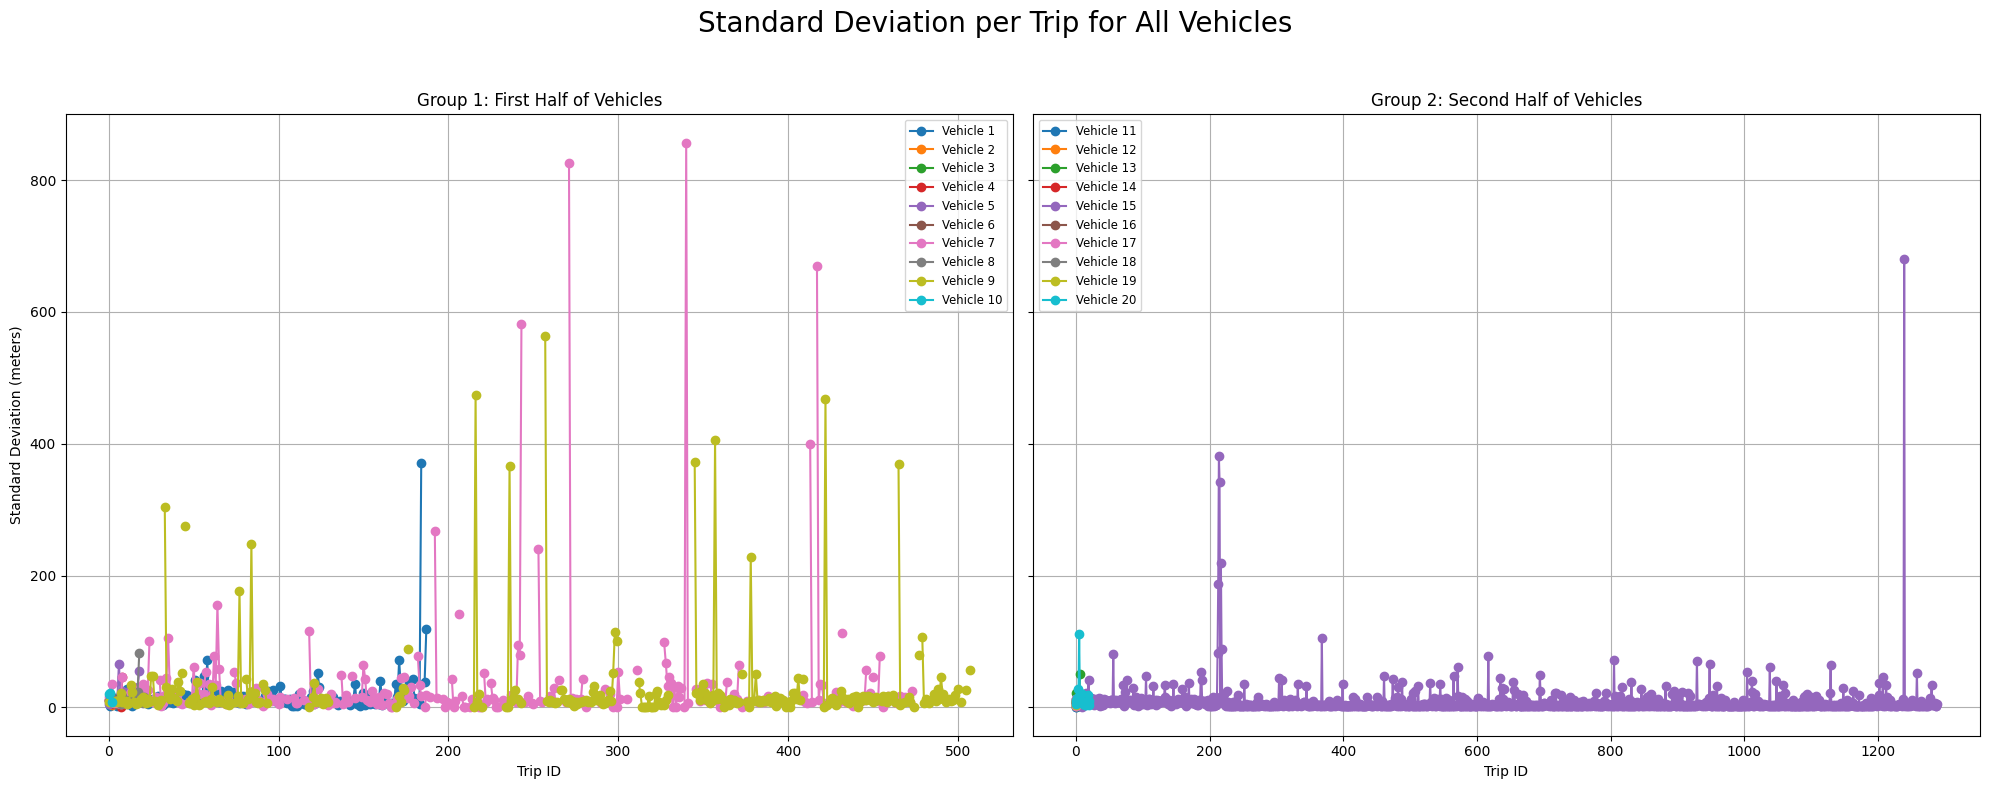

In [ ]:
# Calculate standard deviation per trip and vehicle
std_per_trip = merged_dfs.groupby(['vehicleId', 'trip_id'])['distance_m'].std().reset_index()
std_per_trip.rename(columns={'distance_m': 'std_trip'}, inplace=True)

# Get all unique vehicles
all_vehicles = std_per_trip['vehicleId'].unique()
mid_point = len(all_vehicles) // 2
vehicles_group1 = all_vehicles[:mid_point]
vehicles_group2 = all_vehicles[mid_point:]

# Set up 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot for first group
for vehicle in vehicles_group1:
    vehicle_data = std_per_trip[std_per_trip['vehicleId'] == vehicle]
    axes[0].plot(vehicle_data['trip_id'], vehicle_data['std_trip'], marker='o', label=f'Vehicle {vehicle}')

axes[0].set_title('Group 1: First Half of Vehicles')
axes[0].set_xlabel('Trip ID')
axes[0].set_ylabel('Standard Deviation (meters)')
axes[0].legend(fontsize="small")
axes[0].grid(True)

# Plot for second group
for vehicle in vehicles_group2:
    vehicle_data = std_per_trip[std_per_trip['vehicleId'] == vehicle]
    axes[1].plot(vehicle_data['trip_id'], vehicle_data['std_trip'], marker='o', label=f'Vehicle {vehicle}')

axes[1].set_title('Group 2: Second Half of Vehicles')
axes[1].set_xlabel('Trip ID')
axes[1].legend(fontsize="small")
axes[1].grid(True)

# Overall title
plt.suptitle('Standard Deviation per Trip for All Vehicles', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save plot
plt.savefig(f"{PLOT_FOLDER_PATH}Standard_Deviation_per_Trip_For_All_Vehicles.png")
plt.show()


In [ ]:
merged_dfs = merge_merged_dfs(ALL_merged_dfsS)

# Print all unique vehicleId values from the merged DataFrame
unique_vehicle_ids = merged_dfs['vehicleId'].unique()
print(f"Unique vehicleIds in the merged DataFrame: {unique_vehicle_ids}")



#### Find the mean distance in all data

In [ ]:
# Filter out rows where distance_m is 0.0
filtered_dfs = merged_dfs[merged_dfs['distance_m'] != 0.0]

# Find the mean distance across all data
mean_distance_nonzero = filtered_dfs['distance_m'].mean()

# Print the result
print(f"The mean distance (excluding 0.0) is: {mean_distance_nonzero}")


### Plot all trips of all vehicles

In [ ]:
# Generate a list of unique vehicle IDs
vehicle_ids = merged_dfs['vehicleId'].unique()  # Get unique vehicle IDs from merged_dfs
num_vehicles = len(vehicle_ids)
colors = cm.get_cmap('tab20', num_vehicles)  # Choose a colormap with sufficient colors

# Plot the data
plt.figure(figsize=(15, 10))
plt.title('Each vehicle\'s trip')

# Iterate through the unique vehicle IDs
for i, vehicle_id in enumerate(vehicle_ids):
    # Filter the data for each vehicle ID
    vehicle_data = merged_dfs[merged_dfs['vehicleId'] == vehicle_id]
    
    # Assign a color for each vehicle
    color = colors(i)
    
    # Plot the data for the current vehicle
    plt.scatter(vehicle_data['lng'], vehicle_data['lat'], label=f'Vehicle {vehicle_id}', color=color)

# Plot formatting
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend outside the plot
plt.tight_layout()

# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "all_trips_per_vehicle.png")

# Save the plot
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Plot saved to {plot_save_path}")

# Show the plot (optional, can be removed if not needed)
plt.show()


### Plot velocity

#### 5️⃣ KDE Plot (Smooth Distribution)

#### What Does "Density" Stand For?

In **statistics and data visualization**, "density" refers to how frequently data points appear in a given range. Instead of showing counts (like a histogram), **density plots estimate the probability distribution** of the data.

- **Higher density (taller peaks)** means more data points are in that range.
- **Lower density (shorter peaks)** means fewer data points are in that range.

For example:
- A **histogram** shows how many data points fall into specific bins.
- A **KDE plot (Kernel Density Estimate)** smooths the histogram to show a continuous probability distribution.


In [ ]:
# Flatten the velocity data
all_velocities = merged_dfs['velocity'].tolist() 


total_lines = len(merged_dfs)

# Create the plot
plt.figure(figsize=(10, 6))
plt.title(f'Velocity Density (KDE Plot)')
plt.xlabel('Velocity')

# Plot the KDE (Kernel Density Estimate)
sns.kdeplot(all_velocities, fill=True, color='b')  

plt.grid(True)

# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "velocity_density_kde_plot.png")

# Save the plot
plt.savefig(plot_save_path)

# Show the plot
plt.show()

# Print the number of rows processed
print(f"Total rows processed: {total_lines}")


### Create orientations
- Calculate which the **30 degrees turns** on coordinatess
- Add <u>**orientation column for the 30 degrees turns</u>** to corresponding coordinates
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

In [ ]:
def process_coordinates(merged_dfs):
    gmerged_dfs = gpd.GeoDataFrame(merged_dfs, geometry=gpd.points_from_xy(merged_dfs['lng'], merged_dfs['lat']))
    
    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
        
        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        return (math.degrees(bearing) + 360) % 360  
    
    def get_orientation(bearing):
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        return directions[round(bearing / 45) % 8]
    
    def get_latest_and_next_coordinates(gmerged_dfs):
        latest_coordinate = gmerged_dfs.iloc[-1]  
        next_coordinates = []
        
        for idx in range(len(gmerged_dfs) - 1):
            current_row = gmerged_dfs.iloc[idx]
            next_row = gmerged_dfs.iloc[idx + 1]
            bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
            orientation = get_orientation(bearing)
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'], bearing, orientation))
        
        return latest_coordinate, next_coordinates
    
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gmerged_dfs)
    
    print(Fore.YELLOW + "\nLatest Coordinate:" + Style.RESET_ALL)
    print(latest_coordinate[['lat', 'lng']])
    
    print(Fore.YELLOW + "\nNext Coordinates with Orientation:" + Style.RESET_ALL)
    for coord in next_coordinates:
        print(f"Current: ({coord[0]}, {coord[1]}) -> Next: ({coord[2]}, {coord[3]}) | Bearing: {coord[4]:.2f}° | Orientation: {coord[5]}")
    
    return latest_coordinate, next_coordinates

def add_bearing_and_orientation_columns(merged_dfs):
    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
        
        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        return (math.degrees(bearing) + 360) % 360  
    
    def get_orientation(bearing):
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        return directions[round(bearing / 45) % 8]
    
    bearings = []
    orientations = []
    
    for idx in range(len(merged_dfs) - 1):
        current_row = merged_dfs.iloc[idx]
        next_row = merged_dfs.iloc[idx + 1]
        bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
        orientation = get_orientation(bearing)
        
        bearings.append(bearing)
        orientations.append(orientation)
    
    bearings.append(None)  # Last row has no next point, so bearing is None
    orientations.append("")  
    
    merged_dfs['bearing'] = bearings
    merged_dfs['orientation'] = orientations
    
    return merged_dfs

latest_coordinate, next_coordinates = process_coordinates(merged_dfs)
merged_dfs = add_bearing_and_orientation_columns(merged_dfs)

print(Fore.YELLOW + "Updated DataFrame:" + Style.RESET_ALL)
print(merged_dfs.head())


#### Calculate Bearing diff

In [ ]:
def calculate_bearing_difference(df):
    """
    Calculates the absolute difference between consecutive bearing values within each trip_id.
    
    Parameters:
        df (pd.DataFrame): A DataFrame containing 'trip_id' and 'bearing' columns.
        
    Returns:
        pd.DataFrame: DataFrame with a new column 'bearing_diff'.
    """
    if 'bearing' not in df.columns or df.empty:
        return df

    def compute_bearing_diff(group):
        group = group.copy()
        group['bearing_diff'] = group['bearing'].diff().abs().fillna(0.0)
        return group

    df = df.groupby('trip_id', group_keys=False).apply(compute_bearing_diff)
    df['bearing_diff'] = df['bearing_diff'].round(2)

    # Fix potential weird index issue from groupby().apply()
    return df.reset_index(drop=True)


merged_dfs = calculate_bearing_difference(merged_dfs)
print(merged_dfs.columns)  # 'bearing_diff' should now exist


## Plot **velocities on coordinates**

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Velocities on Coordinates')
plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')   # Corrected label
plt.grid()

# Plot the scatter plot with velocity as the color
scatter = plt.scatter(
    merged_dfs['lng'],  # Longitude on X-axis
    merged_dfs['lat'],  # Latitude on Y-axis
    c=merged_dfs['velocity'], 
    cmap='viridis', 
    s=100, 
    edgecolors='k'  # Ensure this matches the marker style
)

# Add color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Velocities')

plt.tight_layout()

# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}velocities_on_coordinates_scatter.png")

plt.show()


## Data **Cleaning**

### Filter **noise velocties** (>=51)

In [ ]:
NOISE_VELOCITIES = 60
count_noise_vel = (merged_dfs['velocity'] > NOISE_VELOCITIES).sum()  # Count the rows where 'velocity' >= 51
total_rows = len(merged_dfs)  # Total number of rows in the DataFrame

# Calculate the percentage
percentage = (count_noise_vel / total_rows) * 100

# Print the results
print(f"Total # of lines of DataSet: {total_rows}")
print(f"Num of velocities >= {NOISE_VELOCITIES}: {count_noise_vel}")
print(Fore.YELLOW + f"Percentage of velocities >= {NOISE_VELOCITIES}: {percentage:.2f}%"+ Style.RESET_ALL)


### Plot percentage of **noise velocities**

In [ ]:
NOISE_VELOCITIES = 61
count_noise_vel = (merged_dfs['velocity'] > NOISE_VELOCITIES).sum()
total_rows = len(merged_dfs)
percentage = (count_noise_vel / total_rows) * 100

labels = ['Velocities ≤ 60 km/h', 'Velocities ≥ 61 km/h']
sizes = [total_rows - count_noise_vel, count_noise_vel]
colors = ['#66b3ff', '#ff6666']
explode = (0, 0.1)

# Δημιουργία διαγράμματος
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')
plt.title(f'Distribution of Velocities\n(Threshold: {NOISE_VELOCITIES} km/h)')

# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Distribution_of_Velocitieses_scatter_inside_Tripoli's_BOX.png")

plt.show()


### Calculate percentage of Tripoli's BBOX data in comparison with all data

In [ ]:
# tripoli_bbox = {
#     'latMin': 37.49764419371479,
#     'latMax': 37.56244081620044,
#     'lngMin': 22.344992459074458,
#     'lngMax': 22.521463853839485
# }

# Extract bounding box coordinates from the dictionary
latMin = tripoli_bbox['latMin']
latMax = tripoli_bbox['latMax']
lngMin = tripoli_bbox['lngMin']
lngMax = tripoli_bbox['lngMax']

# Filter rows that are within the bounding box
in_bbox = merged_dfs[(merged_dfs['lat'] >= latMin) & (merged_dfs['lat'] <= latMax) &
                     (merged_dfs['lng'] >= lngMin) & (merged_dfs['lng'] <= lngMax)]

# Calculate the percentage of rows in the bounding box
percentage_in_bbox = (len(in_bbox) / len(merged_dfs)) * 100

# Change the color based on the percentage
color = Fore.GREEN if percentage_in_bbox == 100 else Fore.RED

# Print the result with the selected color
print(color + f"Percentage of rows inside the bounding box: {percentage_in_bbox:.2f}%" + Style.RESET_ALL)



In [ ]:
PLOT_FOLDER_PATH = "./Plots/"

### Get velocity data and vehicle IDs for rows within specified **BBOX**

In [ ]:
# Assuming tripoli_bbox dictionary is defined as follows:
# tripoli_bbox = {
#     'latMin': 37.49764419371479,
#     'latMax': 37.56244081620044,
#     'lngMin': 22.344992459074458,
#     'lngMax': 22.521463853839485
# }

def get_velocity_in_area(df, bbox):
    """
    Get velocity data and vehicle IDs for rows within specified latitude and longitude bounds.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        bbox (dict): The bounding box coordinates containing latMin, latMax, lngMin, lngMax.

    Returns:
        pd.DataFrame: A DataFrame containing 'vehicleId' and 'velocity' within the specified area.
    """
    try:
        # Extract bounding box coordinates from the dictionary
        latMin, latMax = bbox['latMin'], bbox['latMax']
        lngMin, lngMax = bbox['lngMin'], bbox['lngMax']
        
        # Filter rows based on latitude and longitude ranges
        filtered_df = df[
            (df['lat'] >= latMin) & (df['lat'] <= latMax) &
            (df['lng'] >= lngMin) & (df['lng'] <= lngMax)
        ]
        
        # Return the subset of DataFrame with 'vehicleId' and 'velocity' columns
        return filtered_df[['vehicleId', 'velocity']]

    except KeyError as e:
        print(f"Error: Missing required column: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])


# Assuming the tripoli_bbox dictionary is already defined
# Get filtered velocities using the tripoli_bbox dictionary
BBOX_df = get_velocity_in_area(merged_dfs, tripoli_bbox)

# Optionally, print the result
print(BBOX_df.head())


In [ ]:
merged_dfs.dtypes

## Calculate **Acceleration**

In [ ]:
# Compute velocity difference between consecutive rows
merged_dfs['velocity_diff'] = merged_dfs['velocity'].diff().fillna(0.0)

# Compute acceleration: velocity change / time change
merged_dfs['acceleration'] = (merged_dfs['velocity_diff'] * (1000/3600)) / merged_dfs['seconds_diff']

# Reset acceleration to 0.0 when either vehicleId or trip_id changes
merged_dfs.loc[(merged_dfs['vehicleId'].diff() != 0) | (merged_dfs['trip_id'].diff() != 0), 'acceleration'] = 0.0

# Handle NaN values (e.g., first row, or division by zero)
merged_dfs['acceleration'] = merged_dfs['acceleration'].fillna(0.0)

### Plot Acceleration **stats**

In [ ]:
# Group by vehicleId και trip_id και υπολόγισε std & var της επιτάχυνσης
accel_stats = merged_dfs.groupby(['vehicleId', 'trip_id'])['acceleration'].agg(['std', 'var']).reset_index()
# Group by vehicleId και trip_id και υπολόγισε std & var της επιτάχυνσης
accel_stats = merged_dfs.groupby(['vehicleId', 'trip_id'])['acceleration'].agg(['std', 'var']).reset_index()


plt.figure(figsize=(12, 6))

# Boxplot: τυπική απόκλιση επιτάχυνσης ανά όχημα
accel_stats.boxplot(column='std', by='vehicleId', grid=False, showfliers=False)

plt.title('Distribution of Acceleration STD per Vehicle (Grouped by Trip)')
plt.suptitle('')
plt.xlabel('Vehicle ID')
plt.ylabel('Standard Deviation of Acceleration (m/s²)')


# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Standard_Deviationof_Acceleration.png")
plt.show()




### Avergae Acceleration STD per vehicleId

In [ ]:
mean_std_per_vehicle = accel_stats.groupby('vehicleId')['std'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(mean_std_per_vehicle['vehicleId'].astype(str), mean_std_per_vehicle['std'], color='#66b3ff')
plt.title('Average Acceleration STD per Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Mean Standard Deviation of Acceleration (m/s²)')
plt.tight_layout()


# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Barplot_Mean_Acceleration_STD_per_Vehicle.png")
plt.show()


### Plot Acceleration 

In [ ]:
# Drop the 'index' column if it exists
if 'index' in merged_dfs.columns:
    merged_dfs.drop(columns=['index'], inplace=True)

# Extract x and y values
x = merged_dfs.index.values  # Use the DataFrame's index as x-axis
y = merged_dfs['acceleration'].values  # Acceleration values

# Plot acceleration
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='None', color='r')
plt.title('Acceleration Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (m/s^2)')
plt.grid(True)
plt.tight_layout()

# Save the filtered plot
plt.savefig(f"{PLOT_FOLDER_PATH}velocities_on_coordinates_scatter_filtered.png")
plt.show()  # Display the plot


### Plot Rate of data logging

In [ ]:
df = merged_dfs.copy()

df["timestamp"] = pd.to_datetime(df["dateStoredHuman"])

# Filter data only for vehicleId = 1 (only for example)
df_vehicle = df[df["vehicleId"] == 1]

# Sort data by timestamp
df_vehicle = df_vehicle.sort_values("timestamp").reset_index(drop=True)

# Calculate the time difference between consecutive records
df_vehicle["time_diff"] = df_vehicle["timestamp"].diff().dt.total_seconds()

# Plot time intervals between records
plt.figure(figsize=(10,5))
plt.plot(df_vehicle["timestamp"][1:], df_vehicle["time_diff"][1:], marker='o', linestyle='-', color='b')
plt.xlabel("Timestamp")
plt.ylabel("Time interval between records (seconds)")
plt.title("Irregular Data Logging Rate")
plt.grid()
# Save the filtered plot
plt.savefig(f"{PLOT_FOLDER_PATH}rate_of_data_logging")
plt.show()


### Filter problematic **accelerations** (< -0.50)

In [ ]:
merged_dfs["isProblem"] = merged_dfs["acceleration"].apply(lambda x: 1 if x < -0.50 else 0) #! isProblem: 1 == False, 0 == True

print(merged_dfs)

# Save DF to **csv**

In [ ]:
all_vehicles_data_path = "../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv"
merged_dfs.to_csv(all_vehicles_data_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {all_vehicles_data_path}" + Style.RESET_ALL)

# **Update** DB

In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")  
db = client["Ptyxiaki"]  
collection = db["Powerfleet GPS"] 

# Read CSV file into a Pandas DataFrame
df = pd.read_csv("../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv")

# Convert DataFrame to dictionary format for MongoDB
data = df.to_dict(orient="records")

# Insert data into MongoDB
if data:
    # Delete all existing records
    collection.delete_many({})
    collection.insert_many(data)
    print(Fore.GREEN + "Data inserted successfully!" + Style.RESET_ALL)
else:
    print("CSV is empty, no data inserted.")

In [ ]:
merged_dfs = merge_merged_dfs(ALL_merged_dfsS)

# Print all unique vehicleId values from the merged DataFrame
unique_vehicle_ids = merged_dfs['vehicleId'].unique()
print(f"Unique vehicleIds in the merged DataFrame: {unique_vehicle_ids}")



# Create a dict of all vehcileId converted to DF

In [ ]:
# Method to create unique vehicle dataframes
def create_vehicle_dfs(df: pd.DataFrame) -> dict:
    """
    Create a dictionary of DataFrames, one for each unique vehicleId.

    Args:
        df (pd.DataFrame): The input DataFrame containing a column `vehicleId` to filter by.

    Returns:
        dict: A dictionary where each key is a unique `vehicleId` and each value is a DataFrame 
            containing all rows for that `vehicleId`.
    """
    vehicle_dfs = {}
    # Loop through each unique vehicleId in the DataFrame
    for vehicle_id in df['vehicleId'].unique():
        vehicle_dfs[vehicle_id] = df[df['vehicleId'] == vehicle_id]
    return vehicle_dfs

# Call the function with your merged_df
vehicle_dfs = create_vehicle_dfs(merged_dfs)


print(vehicle_dfs[2])




In [ ]:
a =

## Convert to GeoJson and save them

In [ ]:
def save_vehicle_geojson_csv(df: pd.DataFrame, vehicle_id, output_path="../../DataSets/GeoJSON/"):
    """
    Converts a vehicle-specific DataFrame into GeoJSON-compatible format
    and saves it as a CSV file usable by ArcGIS Online.

    Parameters:
        df (pd.DataFrame): DataFrame containing at least 'latitude' and 'lng' columns.
        vehicle_id (int or str): Unique identifier for the vehicle.
        output_path (str): Directory where the CSV file will be saved.

    Returns:
        str: Full file path of the saved CSV.
    """

    # Ensure required columns exist
    if not {'lat', 'lng'}.issubset(df.columns):
        raise ValueError(f"The DataFrame for vehicle {vehicle_id} must contain 'lat' and 'lng' columns.")
    
    # If DataFrame is empty, log and skip saving
    if df.empty:
        print(f"Skipping vehicle ID {vehicle_id} because its DataFrame is empty.")
        return None

    # Create 'geometry' column with GeoJSON 'Point' features
    df = df.copy()
    df['geometry'] = df.apply(lambda row: json.dumps({
        "type": "Point",
        "coordinates": [row['lng'], row['lat']]
    }), axis=1)

    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    # Define filename and save as CSV
    filename = f'vehicle_{vehicle_id}.csv'
    file_path = os.path.join(output_path, filename)
    df.to_csv(file_path, index=False)

    return file_path

# Assuming vehicle_dfs is a dictionary containing vehicleId as the key and DataFrame as the value
for vid, vdf in vehicle_dfs.items():
    file_path = save_vehicle_geojson_csv(vdf, vid)
    if file_path:
        print(f"Vehicle ID {vid} has been saved to {file_path}")
    else:
        print(f"Vehicle ID {vid} was skipped due to empty DataFrame.")


# **Get data from Overpass API**

In [ ]:
tripoli_bbox = {
    'latMin': 37.49764419371479,
    'latMax': 37.56244081620044,
    'lngMin': 22.344992459074458,
    'lngMax': 22.521463853839485
}

# MongoDB connection
client = MongoClient("mongodb://localhost:27017/")  # Adjust for your MongoDB URI
db = client["Ptyxiaki"]  # Replace with your database name
collection = db["Tripoli's_Roads"]  # Replace with your collection name

# Overpass API endpoint
url = "https://overpass-api.de/api/interpreter"

# Extract bounding box coordinates from tripoli_bbox dictionary
latMin, latMax = tripoli_bbox['latMin'], tripoli_bbox['latMax']
lngMin, lngMax = tripoli_bbox['lngMin'], tripoli_bbox['lngMax']

# Check if collection is empty
if collection.count_documents({}) == 0:
    print(Fore.YELLOW + "Collection is empty. Fetching data from Overpass API..." + Style.RESET_ALL)

    # Overpass QL query to get all types of roads within the bounding box
    query = f"""
    [out:json];
    (
      way({latMin},{lngMin},{latMax},{lngMax})["highway"];
    );
    out geom;
    """

    # Make request to Overpass API
    response = requests.post(url, data=query)

    # Check if the response status is OK (status code 200)
    if response.status_code == 200:
        try:
            # Try to parse the JSON response
            osm_data = response.json()
            elements = osm_data.get("elements", [])

            # Extract relevant data
            named_streets_data = []
            for element in elements:
                tags = element.get("tags", {})
                if 'name' in tags:
                    # Convert string representation of coordinates to list
                    coords_str = element.get("geometry", [])
                    named_streets_data.append([
                        element["id"],
                        "way",
                        tags.get('name', 'Unnamed Street'),
                        tags.get('highway', None),
                        tags.get('name', None),
                        coords_str
                    ])

            # Convert to DataFrame
            df_named_streets = pd.DataFrame(named_streets_data, columns=["id", "type", "name", "highway", "name_en", "coordinates"])

            # Sort the DataFrame by the 'name' column (alphabetically)
            df_named_streets = df_named_streets.sort_values(by='name')

            # Group by the 'name' column and merge coordinates
            df_grouped = df_named_streets.groupby('name').agg({
                'id': 'first',  # Keep the first ID for the road
                'type': 'first',  # Keep the first type (way)
                'highway': 'first',  # Keep the first highway type
                'name_en': 'first',  # Keep the first name_en
                'coordinates': lambda x: sum(x, [])  # Merge all coordinates into one list
            }).reset_index()

            # Convert grouped DataFrame to dictionary and insert it into MongoDB
            collection.insert_many(df_grouped.to_dict('records'))

            print(Fore.GREEN + f"Grouped streets data fetched and saved to MongoDB." + Style.RESET_ALL)

        except ValueError as e:
            # Handle JSON parsing errors
            print(f"Error parsing JSON response: {e}")
    else:
        print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")
        print("Response Text: ", response.text)
else:
    print("Data already exists in the collection. Skipping API request.")



# Create GEOJSON format

In [ ]:
# Initialize the necessary class
ArcGIS_road_creator = RoadGeoJSONCreator()

# Function to get road data in dictionary format
def get_road_data(road_name):
    """Retrieves road data from DataFrame in dictionary format."""
    filtered_data = df_named_streets[df_named_streets['name'] == road_name]

    if not filtered_data.empty:
        for _, row in filtered_data.iterrows():
            coords = row["coordinates"]  # Get the coordinates from the DataFrame
            
            # Check if coordinates are already a list (which they should be)
            if isinstance(coords, list):
                # Coordinates are already a list, so no need for parsing
                road_data = {
                    "name": row["name"],
                    "highway": row["highway"],
                    "name_en": row["name_en"] if "name_en" in row else row["name"],  # Fallback to 'name' if no English name
                    "coordinates": [{"lat": coord['lat'], "lon": coord['lon']} for coord in coords],
                }
            else:
                print(f"Error: Coordinates for road '{road_name}' are not in the expected list format.")
                return None
            
            return road_data
    else:
        print(f"Road with name '{road_name}' not found.")
        return None

# Example usage
road_name_input = "Αλεξάνδρου-Σούτσου"
road_data = get_road_data(road_name_input)

# If road data exists, convert to GeoJSON and save
if road_data:
    # Updated the directory to save the GeoJSON files in the new path
    directory = "../../DataSets/GeoJSON"
    os.makedirs(directory, exist_ok=True)  # Ensure the directory exists
    file_path = os.path.join(directory, f"{road_name_input.replace(' ', '_')}.geojson")
    
    # Check if the GeoJSON creator exists and is callable
    if hasattr(ArcGIS_road_creator, 'from_dict'):
        ArcGIS_road_creator.from_dict(road_data, file_path)
    else:
        print("GeoJSON Creator method 'from_dict' is not available.")
else:
    print("No road data to save.")
